MODELISATION ET SIMULATION

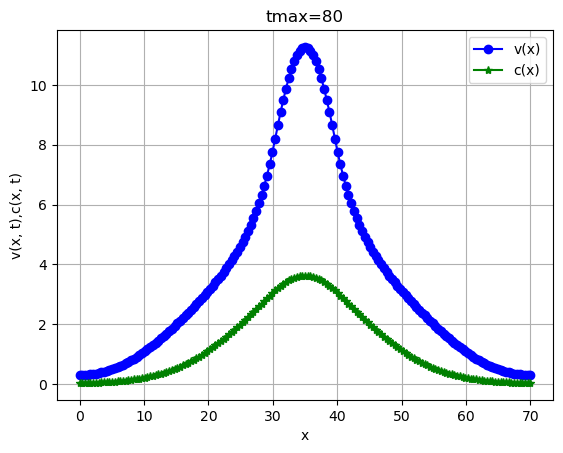

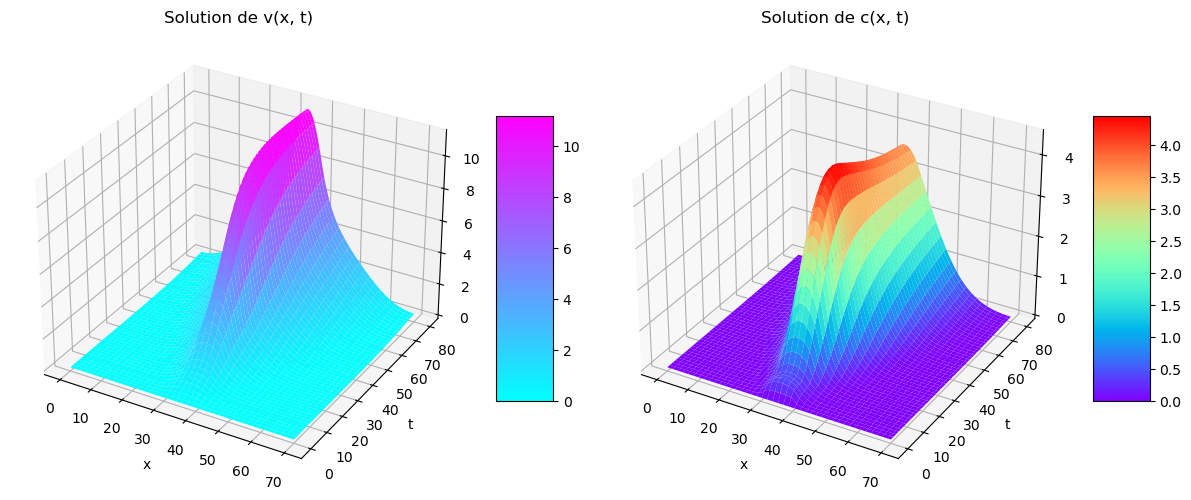

<Figure size 640x480 with 0 Axes>

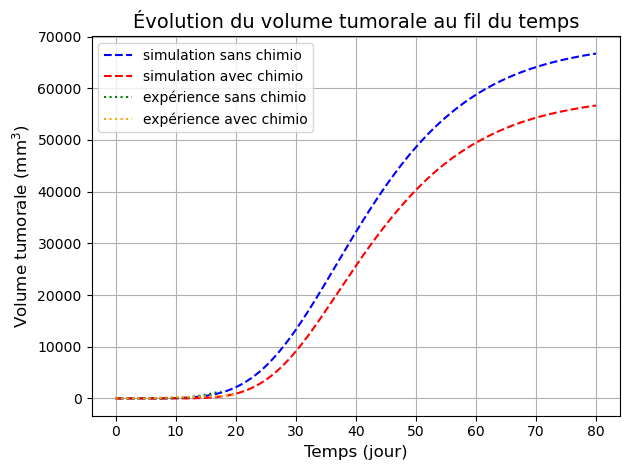

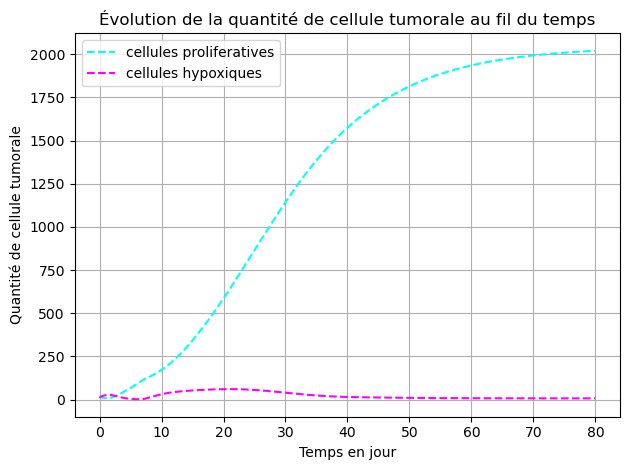

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
#les paramètres
N = 166
Tmin=30
Tmax=40
xmin = 0
xmax = 70
dx = (xmax - xmin) / N
x = np.linspace(xmin, xmax, N + 1)
tmax = 80 # Temps maximal
CFL = 0.25
dt = CFL * (dx ** 2)
t=np.arange(0,tmax,dt)
M=len(t)
# Définir les constantes du modèle
r_p=0.08
r_h=r_p/10
k0=200
r_v=0.5
d_v=0.05
beta=0.5
alpha=0.05
k=0.01
k1=0.001
lamda= 0.01
C=1000
indices_tumeur=np.ones(len(x))
for i in range(len(x)):
     if x[i]<Tmin or x[i]>Tmax:
        indices_tumeur[i]=0
#fonctions

def pj_calcul(E,U):
         return (cold[E] - cold[U]) / (2 * dx)
     # nouvelle valeur de u
def cal_vnew_m(I,U,A,O,E,G,j,pj):
    """
    Calcule la nouvelle valeur de u à l'indice j.
    """
    pjm1 = (cold[j] - cold[I]) / (2 * dx)
    pjm2 = (cold[U] - cold[A]) / (2 * dx)
    return vold[j] - (dt / dx) * (pj * vold[j] * 3 / 2 - 2 * pjm1 * vold[U] + 1 / 2 * pjm2 * vold[I]) + (dt / (dx ** 2)) * (
            vold[E] - 2 * vold[j] + vold[U]) + dt * f(vold[j],cold[j])
def cal_vnew_p(I,U,A,O,E,G,j,pj):
    """
    Calcule la nouvelle valeur de u à l'indice j.
    """
    pjp1=(cold[O]-cold[j])/(2*dx)
    pjp2=(cold[G]-cold[E])/(2*dx)
    return vold[j] +  (dt / dx) * (pj*vold[j]*3/2-2*pjp1*vold[E]+1/2*pjp2*vold[O]) + (dt / (dx **2)) * (
             vold[E] - 2 * vold[j] + vold[U])+dt*f(vold[j],cold[j])
# Initialisation des solutions u et c

vnew = np.zeros(N + 1)
cnew = np.ones(N + 1)
vold = np.zeros(N + 1)
cold = np.zeros(N + 1)
vtx=np.zeros((N+1,M))
ctx=np.zeros((N+1,M))
u_h=np.zeros(M)
u_p=np.zeros(M)
u_p_chimio=np.zeros(M)

#conditions initiales c
cnew[:int(N/3)] = 0#np.maximum(0,0.5 * np.sin((np.pi * np.arange(int(N/3))) / (N/3))) Si initial non null
cnew[int(N/3):int(2*N/3)] = 0
cnew[int(2*N/3):] = 0 #np.maximum(0,0.5 * np.sin((np.pi * np.arange(int(2*N/3), N+1)) / (N/3)))
# Condition initiale pour u
vnew[:int(N/3)] = 0
vnew[int(N/3):int(2*N/3)] = 0#np.maximum(0,-0.5 * np.sin((np.pi * np.arange(int(N/3), int(2*N/3))) / (N/3)))
vnew[int(2*N/3):] = 0.0

u_h[0]=1
u_p[0]=2

vtx[:,0]=vnew
ctx[:,0]=cnew

i=1
maxv=r_v/d_v  # le maximum de u disponible au niveau de la tumeur
maxvpuh=k0+alpha*maxv

def u_h_prime(u_h,u_p,v):
    satur= v/maxv
    return r_h*u_h*np.log((k0+beta*v) / (u_p+u_h)) - max(0,satur*maxvpuh-u_p)*u_h + max(0,u_p-satur*maxvpuh)*u_p
def u_p_prime(u_h,u_p,v):
    satur=v/maxv
    
    return r_p*u_p*np.log((k0+beta*v) / (u_p+u_h)) + (max(0,satur*maxvpuh-u_p)*u_h) - max(0,u_p-satur*maxvpuh)*u_p #r_p*u_p*(1-(u_h+u_p)/(k0+alpha*v)) 
def chimi(C):
    return k*C
def f(v,c):
    """
    Fonction qui décrit la densité de u en fonction de c.
    """

    return r_v*c/(1+c)- d_v*v # equilibre = r_u*c/((1+c)*d_u), compris entre 0 et r_u/d_u
                                 # la source de u est croissante avec c, nulle si c=0, et il y a de la dégradation

def g(x,u_h):
    if x<Tmin or x>Tmax:
        return 0
    else:
        return alpha*u_h
for temps in t[1:]:
    vold[:] = vnew[:]
    cold[:] = cnew[:]
    v_moy_tumeur=sum(vold*indices_tumeur)/sum(indices_tumeur) #somme desuold dans la tumeur/nombre de termes de la somme = u moyen dans la tumeur
    u_h[i]=u_h[i-1]+dt*u_h_prime(u_h[i-1],u_p[i-1],v_moy_tumeur)
    u_p[i]=u_p[i-1]+dt*u_p_prime(u_h[i-1],u_p[i-1],v_moy_tumeur)
    u_p_chimio[0] = u_p[0]
    u_p_chimio[i]=u_p[i]-chimi(C)
         # Mise à jour de u et c

    max_speed=max((abs(cnew[2:]-cnew[:-2]))/(2*dx))
    if max_speed*dt/dx>1:
        print('erreur CFL')
        break

# Dans la boucle :
    for j in range(3, N-2):
        I,U,A,O,E,G=j - 2,j - 1,j - 3,j + 2,j + 1,j + 3
        pj=pj_calcul(E,U)
        if pj >= 0:
            vnew[j] = cal_vnew_m(I,U,A,O,E,G,j,pj)
        else:
            vnew[j] = cal_vnew_p(I,U,A,O,E,G,j,pj)
    j0=0
    pj0=pj_calcul(1,N-1) #j=0
    if pj0> 0:
        vnew[0]=cal_vnew_m(N-2,N-1,N-3,2,1,3,0,pj0)
    else:
        vnew[0]=cal_vnew_p(N-2,N-1,N-3,2,1,3,0,pj0)
    j1=1
    pj1=pj_calcul(2,0) #j=1
    if pj1> 0:
        vnew[1]=cal_vnew_m(N-1,N,N-2,3,2,4,1,pj1)
    else:
        vnew[1]=cal_vnew_p(N-1,N,N-2,3,2,4,1,pj1)
    j2=2
    pj2=pj_calcul(3,1) #j=2
    if pj2> 0:
        vnew[2]=cal_vnew_m(0,1,N-1,4,3,5,2,pj2)
    else:
        vnew[2]=cal_vnew_p(0,1,N-1,4,3,5,2,pj2)
    jN1=N-1
    pjN1=pj_calcul(N,N-2) #j=N-1
    if pjN1> 0:
        vnew[N-1]=cal_vnew_m(N-3,N-2,N-4,1,N,2,N-1,pjN1)
    else:
        vnew[N-1]=cal_vnew_p(N-3,N-2,N-4,1,N,2,N-1,pjN1)
    jN2=N-2
    pjN2=pj_calcul(N-1,N-3)
    if pjN2> 0:
        vnew[N-2]=cal_vnew_p(N-4,N-3,N-5,N,N-1,1,N-2,pjN2)
    else:
        vnew[N-2]=cal_vnew_p(N-4,N-3,N-5,N,N-1,1,N-2,pjN2)
    vnew[N]=vnew[0]
        # nouvelle valeur de c
    for j in range(1,N):
        cnew[j] = cold[j] + dt/dx**2 * (cold[j+1] -2*cold[j]+cold[j-1] ) + dt * g(x[j],u_h[i-1])
        cnew[0]=cold[0]+ dt/dx**2 * (cold[1] - 2*cold[0]+cold[N-1] ) + dt* g(x[0],u_h[i-1])
        cnew[N]=cnew[0]
    vtx[:,i]=vnew
    ctx[:,i]=cnew

    i=i+1


# Affichage de la solution
plt.plot(x, vnew, 'bo-', label='v(x)')
plt.plot(x, cnew, 'g*-', label='c(x)')
plt.xlabel('x')
plt.ylabel('v(x, t),c(x, t)')
plt.title('tmax=80')
plt.legend()
plt.grid(True)
plt.show()
# fisure 3D
X, T = np.meshgrid(x, t)

fig = plt.figure(figsize=(12, 6))

# Première sous-figure pour v(x, t)
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(X, T, vtx.T, cmap='cool')
ax1.set_title('Solution de v(x, t)')
ax1.set_xlabel('x')
ax1.set_ylabel('t')
# Deuxième sous-figure pour c(x, t)
X, T = np.meshgrid(x, t)
ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(X, T, ctx.T, cmap='rainbow')
ax2.set_title('Solution de c(x, t)')
ax2.set_xlabel('x')
ax2.set_ylabel('t')
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)
plt.tight_layout() 
plt.show()

plt.tight_layout()  
plt.show()
plt.figure()
plt.plot(t,(((u_h+u_p)*10)*0.02)**3, label='simulation sans chimio', linestyle='--', color='blue')
plt.plot(t,((u_p_chimio*10)*0.02)**3, label='simulation avec chimio', linestyle='--', color='red')
plt.plot([0,5,7.5,10,12.5,15,17.5],[0,0,20,100,300,700,1350],label='expérience sans chimio', linestyle=':', color='green')
plt.plot([0,5,7.5,10,12.5,15,17.5,20],[0,0,150,300,270,400,450,700],label='expérience avec chimio', linestyle=':', color='orange')
plt.xlabel('Temps (jour)', fontsize=12)  
plt.ylabel('Volume tumorale (mm$^3$)', fontsize=12)  
plt.title('Évolution du volume tumorale au fil du temps', fontsize=14)  
plt.grid(True)  
plt.legend() 
plt.tight_layout()  
plt.show() 


#figure u_h et u_p
plt.figure()  
plt.plot(t, (u_p*10), label='cellules proliferatives', linestyle='--', color='aqua') 
plt.plot(t, (u_h*10), label='cellules hypoxiques', linestyle='--', color='magenta')   
plt.xlabel('Temps en jour')  
plt.ylabel('Quantité de cellule tumorale')  
plt.title('Évolution de la quantité de cellule tumorale au fil du temps')  
plt.grid(True)  
plt.legend()  
plt.tight_layout()  
plt.show()  

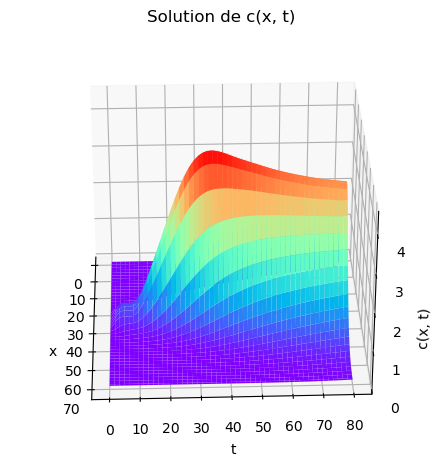

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

# Définition de vos données

X, T = np.meshgrid(x, t)

# Création de la figure et de l'axe 3D
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')

# Fonction pour l'animation
def update_plot(frame):
    ax1.cla()  # Efface l'axe avant de redessiner
    surf1 = ax1.plot_surface(X, T, ctx.T, cmap='rainbow')
    ax1.set_title('Solution de c(x, t)')
    ax1.set_xlabel('x')
    ax1.set_ylabel('t')
    ax1.set_zlabel('c(x, t)')
    ax1.view_init(elev=30, azim=frame)  # Vue 3D

# Création de l'animation
ani = FuncAnimation(fig, update_plot, frames=np.arange(0, 360, 2), interval=50)

# Sauvegarde de l'animation sous forme de fichier vidéo
ani.save('animation1.gif', writer='pillow', fps=30)
plt.show()